# Predicting ENSO
### Source: Libby Barnes
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/ml_tutorial_csu/tree/main/code/)

### Backwards Optimization Code by: XXXXXX
### Edited by: Kirsten Mayer & Will Chapman
Here we are training a classifier to predict whether an El Nino or La Nina event is occuring. The input is a map of global SST, and the output is a classification of either 1=El Nino or 0=La Nino

### Load Libraries

In [48]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl
import copy
import scipy

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from keras import backend as K
sys.setrecursionlimit(1500)

# set seeds
random_seed = 36
np.random.seed(random_seed)
tf.random.set_seed(int(random_seed))

#nice figures
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['font.size'] = 12

## Backards Optimzation Function

### Backwards Optimization

The next cell defines methods that do backwards optimization (or "feature optimization"; Olah *et al.* 2017).  The goal of backwards optimization is to create synthetic input data that maximize the activation of some model component.  "Some model component" could be any of the following (figure from https://distill.pub/2018/building-blocks/).

 - Neuron activation: spatial position $(i, j)$ in channel $k$ of layer $L$
 - Channel activation: all spatial positions in channel $k$ of layer $L$
 - Layer activation: all spatial positions in all channels of layer $L$
 - Spatial activation: spatial position $(i, j)$ in all channels of layer $L$
 - Final prediction: probability that max future storm vorticity $\ge$ threshold
 
<img src="model_components.png" alt="Model components" width="1000" />

Backwards optimization uses gradient descent to create synthetic input data ($32 \times 32$ grids of reflectivity, temperature, $u$-wind, and $v$-wind).  Gradient descent requires an initial seed, which could be any of the following:

 - Uniform grids ($e.g.$, all zeros or all ones)
 - Random grids ($e.g.$, Gaussian noise)
 - A real dataset example

We will use real dataset examples, because these produce the most physically realistic output.

In [40]:
def _gradient_descent_for_bwo(
        cnn_model_object, loss_tensor, init_function_or_matrices,
        num_iterations, learning_rate):
    """Does gradient descent (the nitty-gritty part) for backwards optimization.

    :param cnn_model_object: Trained instance of `keras.models.Model`.
    :param loss_tensor: Keras tensor, defining the loss function to be
        minimized.
    :param init_function_or_matrices: Either a function or list of numpy arrays.

    If function, will be used to initialize input matrices.  See
    `create_gaussian_initializer` for an example.

    If list of numpy arrays, these are the input matrices themselves.  Matrices
    should be processed in the exact same way that training data were processed
    (e.g., normalization method).  Matrices must also be in the same order as
    training matrices, and the [q]th matrix in this list must have the same
    shape as the [q]th training matrix.

    :param num_iterations: Number of gradient-descent iterations (number of
        times that the input matrices are adjusted).
    :param learning_rate: Learning rate.  At each iteration, each input value x
        will be decremented by `learning_rate * gradient`, where `gradient` is
        the gradient of the loss function with respect to x.
    :return: list_of_optimized_input_matrices: length-T list of optimized input
        matrices (numpy arrays), where T = number of input tensors to the model.
        If the input arg `init_function_or_matrices` is a list of numpy arrays
        (rather than a function), `list_of_optimized_input_matrices` will have
        the exact same shape, just with different values.
    """

    if isinstance(cnn_model_object.input, list):
        list_of_input_tensors = cnn_model_object.input
    else:
        list_of_input_tensors = [cnn_model_object.input]

    num_input_tensors = len(list_of_input_tensors)
    
    print(loss_tensor)
    print(list_of_input_tensors)
        
    list_of_gradient_tensors = tf.compat.v1.keras.backend.gradients(loss_tensor, list_of_input_tensors)     
    
    for i in range(num_input_tensors):
        list_of_gradient_tensors[i] /= K.maximum(
            K.sqrt(K.mean(list_of_gradient_tensors[i] ** 2)),
            K.epsilon()
        )

    inputs_to_loss_and_gradients = K.function(
        list_of_input_tensors + [K.learning_phase()],
        ([loss_tensor] + list_of_gradient_tensors)
    )

    if isinstance(init_function_or_matrices, list):
        list_of_optimized_input_matrices = copy.deepcopy(
            init_function_or_matrices)
    else:
        list_of_optimized_input_matrices = [None] * num_input_tensors

        for i in range(num_input_tensors):
            these_dimensions = np.array(
                [1] + list_of_input_tensors[i].get_shape().as_list()[1:],
                dtype=int)

            list_of_optimized_input_matrices[i] = init_function_or_matrices(
                these_dimensions)

    for j in range(num_iterations):
        these_outputs = inputs_to_loss_and_gradients(
            list_of_optimized_input_matrices + [0])

        if np.mod(j, 1000) == 0:
            print('Loss after {0:d} of {1:d} iterations: {2:.2e}'.format(
                j, num_iterations, these_outputs[0]))

        for i in range(num_input_tensors):
            list_of_optimized_input_matrices[i] -= (
                these_outputs[i + 1] * learning_rate)

    print('Loss after {0:d} iterations: {1:.2e}'.format(
        num_iterations, these_outputs[0]))
    return list_of_optimized_input_matrices


def bwo_for_class(
        cnn_model_object, target_class, init_function_or_matrices,
        num_iterations=4000,
        learning_rate=0.00000001):
    """Does backwards optimization to maximize probability of target class.

    :param cnn_model_object: Trained instance of `keras.models.Model`.
    :param target_class: Synthetic input data will be created to maximize
        probability of this class.
    :param init_function_or_matrices: See doc for `_gradient_descent_for_bwo`.
    :param num_iterations: Same.
    :param learning_rate: Same.
    :return: list_of_optimized_input_matrices: Same.
    """

    target_class = int(np.round(target_class))
    num_iterations = int(np.round(num_iterations))

    assert target_class >= 0
    assert num_iterations > 0
    assert learning_rate > 0.
    assert  learning_rate < 1.

    num_output_neurons = (
        cnn_model_object.layers[-1].output.get_shape().as_list()[-1]
    )

    if num_output_neurons == 1:
        assert target_class <= 1

        if target_class == 1:
            loss_tensor = K.mean(
                (cnn_model_object.layers[-1].output[..., 0] - 1) ** 2
            )
        else:
            loss_tensor = K.mean(
                cnn_model_object.layers[-1].output[..., 0] ** 2
            )
    else:
        assert target_class < num_output_neurons

        loss_tensor = K.mean(
            (cnn_model_object.layers[-1].output[..., target_class] - 1) ** 2
        )

    return _gradient_descent_for_bwo(
        cnn_model_object=cnn_model_object, loss_tensor=loss_tensor,
        init_function_or_matrices=init_function_or_matrices,
        num_iterations=num_iterations, learning_rate=learning_rate)

## Preprocessing
Load in the data from the netcdf. This is ERSSTv5 which has been deseasoned, linearly detrended, and has a 5 month lookback running mean applied. From this, we can calculate the Nino3.4 index.

In [6]:
filename = 'ERSSTv5_deseasoneddetrended_5monthrunningmean_1950-2021.nc'
sstds = xr.open_dataset(filename,decode_times=False)
sst = sstds.sst
sst = sst.where((sst.lat <= 30) & (sst.lat >= -30), drop=True)
lat = np.asarray(sst.lat)
lon = np.asarray(sst.lon)
time = sstds.time

ninolat1 = -5
ninolat2 = 5
ninolon1 = 190
ninolon2 = 240

sstnino = np.asarray(sst.sel(lat=slice(ninolat1,ninolat2),lon=slice(ninolon1,ninolon2)))
nino34 = np.nanmean(sstnino,axis=(1,2))

## Data preparation
First, we need to include only samples where nino event is occuring (i.e. nino3.4>0.5 or nino3.4<-0.5). Then, we will divide the sst input and nino3.4 output into training, validation and testing chunks.

In [7]:
nino_occur = nino34[(nino34>0.5) | (nino34<-0.5)] # only samples where nino event occurs
nino_occur[nino_occur>0.5] = 1 # make into categorical format, 1 for El Nino and 0 for La Nina
nino_occur[nino_occur<0.5] = 0
nino_occur = tf.keras.utils.to_categorical(nino_occur) # format accepted by NN
sizefull = nino_occur.shape[0]

train_val_test = [0.7,0.85,1] # set train/val/test fraction

sst = np.asarray(sst)
sizesst = sst.shape
sstnino_occur = sst[(nino34>0.5) | (nino34<-0.5),:,:] # grab sst samples where nino occurs
sstnino_occur = np.reshape(sstnino_occur,(sizefull,sizesst[1]*sizesst[2])) # reshape latxlon to vectors

trainind = range(int(train_val_test[0]*sizefull))
valind = range(int(train_val_test[0]*sizefull),int(train_val_test[1]*sizefull))
testind = range(int(train_val_test[1]*sizefull),int(train_val_test[2]*sizefull))

# divide into training/validation/testing
sst_train = sstnino_occur[trainind,:]
sst_val = sstnino_occur[valind,:]
sst_test = sstnino_occur[testind,:]

nino_train  = nino_occur[trainind]
nino_val = nino_occur[valind]
nino_test = nino_occur[testind]

In [8]:
sst_std = np.std(sst_train,axis=0) # standardized by the TRAINING STD

sst_train = np.divide(sst_train,sst_std)
sst_train[np.isnan(sst_train)] = 0 # set all nans to zeros (they are learned to be ignored)
sst_val = np.divide(sst_val,sst_std)
sst_val[np.isnan(sst_val)] = 0
sst_test = np.divide(sst_test,sst_std)
sst_test[np.isnan(sst_test)] = 0

## Load Trained Neural Network

In [9]:
model = tf.keras.models.load_model('saved_model/ENSOmodel.h5')

## Model evaluation
How does the model do on unseen data?

In [10]:
nino_pred = model.predict(sst_test) # make predictions for test data

nino_pred = np.argmax(nino_pred,axis=1)
nino_true = np.argmax(nino_test,axis=1)

modelcorr = nino_pred==nino_true
nmodelcorr = modelcorr[modelcorr].shape[0]
ntest = nino_true.shape[0]
print('Model accuracy on testing is %f%%' %(100*nmodelcorr/ntest))

Model accuracy on testing is 100.000000%


/glade/u/home/kjmayer/.conda/envs/tf2-env/lib/python3.10/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


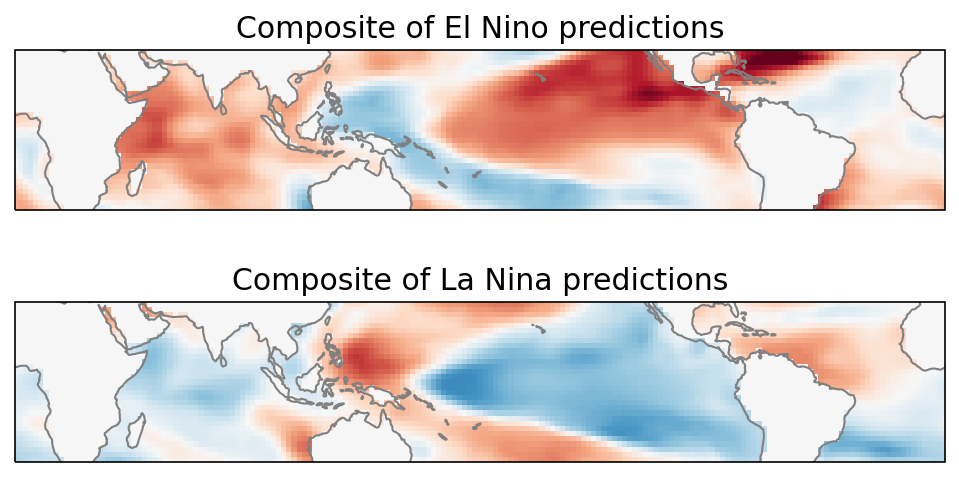

In [13]:
elninopred = (nino_pred==1)
laninapred = (nino_pred==0)

elnino_sst = sst_test[elninopred,:]
elnino_sst = np.reshape(elnino_sst,(elnino_sst.shape[0],sizesst[1],sizesst[2]))
lanina_sst = sst_test[laninapred,:]
lanina_sst = np.reshape(lanina_sst,(lanina_sst.shape[0],sizesst[1],sizesst[2]))

elninoplot = np.mean(elnino_sst,axis=0)
laninaplot = np.mean(lanina_sst,axis=0)

projection = ccrs.PlateCarree(central_longitude=180)
transform = ccrs.PlateCarree()

plt.figure(figsize=(8,4))

ax1=plt.subplot(2,1,1,projection=projection)
ax1.pcolormesh(lon,lat,elninoplot,vmin=-2,vmax=2,cmap='RdBu_r',transform=transform)
ax1.coastlines(color='gray')
plt.title('Composite of El Nino predictions')

ax2=plt.subplot(2,1,2,projection=projection)
ax2.pcolormesh(lon,lat,laninaplot,vmin=-2,vmax=2,cmap='RdBu_r',transform=transform)
ax2.coastlines(color='gray')
plt.title('Composite of La Nina predictions')

plt.show()

## Calculate Backwards Optimization

In [66]:
elnino_optimized_predictor_matrix_norm = bwo_for_class(
    cnn_model_object=model, target_class=1,
    init_function_or_matrices=[np.expand_dims(0*np.random.random(size=len(sst_train[0,:])),axis=0)],
    num_iterations=4000,
    learning_rate=0.001
)

lanina_optimized_predictor_matrix_norm = bwo_for_class(
    cnn_model_object=model, target_class=0,
    init_function_or_matrices=[np.expand_dims(0*np.random.random(size=len(sst_train[0,:])),axis=0)],
    num_iterations=4000,
    learning_rate=0.001
)

Tensor("Mean_22:0", shape=(), dtype=float32)
[<tf.Tensor 'dense_input_1:0' shape=(None, 5580) dtype=float32>]
Loss after 0 of 4000 iterations: 2.86e-01
Loss after 1000 of 4000 iterations: 1.93e-06
Loss after 2000 of 4000 iterations: 7.38e-07
Loss after 3000 of 4000 iterations: 4.56e-07
Loss after 4000 iterations: 3.30e-07
Tensor("Mean_24:0", shape=(), dtype=float32)
[<tf.Tensor 'dense_input_1:0' shape=(None, 5580) dtype=float32>]
Loss after 0 of 4000 iterations: 2.17e-01
Loss after 1000 of 4000 iterations: 1.93e-06
Loss after 2000 of 4000 iterations: 7.43e-07
Loss after 3000 of 4000 iterations: 4.60e-07
Loss after 4000 iterations: 3.33e-07


In [67]:
bwo_elnino_sstmap = elnino_optimized_predictor_matrix_norm[0].reshape(sizesst[1],sizesst[2])
bwo_lanina_sstmap = lanina_optimized_predictor_matrix_norm[0].reshape(sizesst[1],sizesst[2])

## Let's check... is it truly optimal?
An input that is "optimal": 
- el nino: [0,1]
- la nina: [1,0]

In [70]:
print('El Nino Optimal Input Prediction:')
print(np.round(model.predict(np.expand_dims(bwo_elnino_sstmap.reshape(lat.shape[0]*lon.shape[0]),axis=0))[0],3))
print('\nLa Nina Optimal Input Prediction:')
print(np.round(model.predict(np.expand_dims(bwo_lanina_sstmap.reshape(lat.shape[0]*lon.shape[0]),axis=0))[0],3))

El Nino Optimal Input Prediction:
[0.001 0.999]

La Nina Optimal Input Prediction:
[0.999 0.001]


## Yes? Plot the optimal SST input:

In [74]:
# smooth to make plot prettier
bwo_lanina_sstmap = scipy.ndimage.gaussian_filter(bwo_lanina_sstmap, sigma=0.7)
bwo_elnino_sstmap = scipy.ndimage.gaussian_filter(bwo_elnino_sstmap, sigma=0.7)

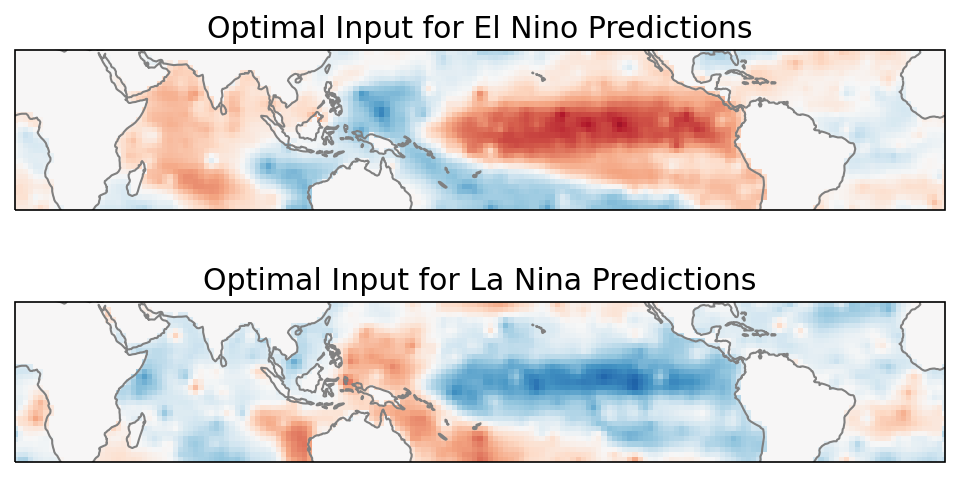

In [75]:
projection = ccrs.PlateCarree(central_longitude=180)
transform = ccrs.PlateCarree()

minval = -2
maxval = 2

plt.figure(figsize=(8,4))

ax1=plt.subplot(2,1,1,projection=projection)
ax1.pcolormesh(lon,lat,bwo_elnino_sstmap*(np.abs(sst[0,:,:].squeeze())>0),vmin=minval,vmax=maxval,cmap='RdBu_r',transform=transform)
ax1.coastlines(color='gray')
plt.title('Optimal Input for El Nino Predictions')

ax1=plt.subplot(2,1,2,projection=projection)
ax1.pcolormesh(lon,lat,bwo_lanina_sstmap*(np.abs(sst[0,:,:].squeeze())>0),vmin=minval,vmax=maxval,cmap='RdBu_r',transform=transform)
ax1.coastlines(color='gray')
plt.title('Optimal Input for La Nina Predictions')

plt.show()